In [1]:
%load_ext autoreload
%autoreload 2

import dataclasses
import logging
import pathlib

import numpy as np
import pandas as pd
import sklearn.ensemble as ensemble
import sklearn.metrics
import sklearn.model_selection
import xarray as xr

import a6
import a6.datasets.coordinates as _coordinates
import a6.datasets.variables as _variables
import a6.utils as utils

WORKER_ID = 4

utils.logging.create_logger(
    global_rank=WORKER_ID,
    local_rank=WORKER_ID,
    verbose=True,
)

logger = logging.getLogger("notebook")


turbine_data_dir = pathlib.Path(
    "/p/home/jusers/emmerich1/juwels/data/production"
)
preprocessed_data_dir = pathlib.Path(
    "/p/home/jusers/emmerich1/juwels/data/production-preprocessed"
)
results_dir = pathlib.Path(
    "/p/project/deepacf/maelstrom/emmerich1/data/forecast-errors"
)

turbine_files = a6.utils.paths.list_files(
    turbine_data_dir, pattern="**/*.nc", recursive=True
)

plots = pathlib.Path(
    "/p/project/deepacf/maelstrom/emmerich1/plots"
)

results = xr.open_dataset("/p/project/deepacf/maelstrom/emmerich1/data/pca_kpca_kmeans_lswrs_29_40.nc")
results_40 = results.sel(k=40)
gwl = xr.open_dataset("/p/home/jusers/emmerich1/juwels/code/a6/src/tests/data/gwl.nc")
dcv2 = xr.open_dataset("/p/project/deepacf/maelstrom/emmerich1/data/dcv2-lswrs.nc")

lswrs = [None, gwl["GWL"], results_40["PCA"], results_40["kPCA"], dcv2["DCv2"]]

coordinates: _coordinates.Coordinates = _coordinates.Coordinates()
turbine_variables: _variables.Turbine = a6.datasets.variables.Turbine()

turbines_with_preprocessed_data = [
    path
    for path in turbine_files
    if (
        preprocessed_data_dir / f"{path.name.replace('.nc', '')}/turbine.nc"
    ).exists()
]
print(f"Number of turbines: {len(turbines_with_preprocessed_data)}")

Number of turbines: 40


In [3]:
gwl["time"] = dcv2["time"]
gwl.time

ValueError: conflicting sizes for dimension 'time': length 15777 on 'GWL' and length 21826 on {'time': 'time'}

In [2]:
@dataclasses.dataclass
class Errors:
    nmae: float
    nrmse: float


def _create_forecast(
    date: pd.Timestamp,
    gs: sklearn.model_selection.GridSearchCV,
    weather_data: list[xr.DataArray],
    turbine: xr.Dataset,
    turbine_variables: _variables.Turbine,
) -> tuple[np.ndarray, pd.Timestamp]:
    logger.debug("Creating forecast for %s", date)
    
    turbine_sub = a6.datasets.methods.select.select_for_date(turbine, date=date)[
        turbine_variables.production
    ]
    y_true = a6.features.methods.reshape.sklearn.transpose(turbine_sub)

    if y_true.size < 24:
        logger.warning(
            (
                "Less than 24 time steps for production data for date=%s, "
                "returning empty array"
            ),
            date
        )
        return np.array([]), date

    weather_forecast = [a6.datasets.methods.select.select_for_date(d, date=date) for d in weather_data]
    X_forecast = a6.features.methods.reshape.sklearn.transpose(  # noqa: N806
        *weather_forecast
    )


    y_pred = gs.predict(X_forecast)
    return y_pred, date

In [ ]:
if WORKER_ID is not None and WORKER_ID >= len(turbine_files):
    logger.warning("Exiting: no file to process")
    raise RuntimeError()


result = {}

for i, turbine_path in enumerate(turbine_files):
    if WORKER_ID is not None and i != WORKER_ID:
        continue

    logger.info(
        "Processing turbine %i/%i (path=%s)",
        i,
        len(turbine_files),
        turbine_path,
    )

    turbine_name = turbine_path.name.replace(".nc", "")

    turbine_path: pathlib.Path = (
        preprocessed_data_dir / f"{turbine_name}/turbine.nc"
    )
    pl_path: pathlib.Path = (
        preprocessed_data_dir / f"{turbine_name}/pl.nc"
    )
    ml_path: pathlib.Path = (
        preprocessed_data_dir / f"{turbine_name}/ml.nc"
    )
    sfc_path: pathlib.Path = (
        preprocessed_data_dir / f"{turbine_name}/sfc.nc"
    )

    logger.info("Reading preprocessed data")

    try:
        turbine = xr.open_dataset(turbine_path)
    except FileNotFoundError:
        logger.exception(
            "No preprocessed data for turbine %s found in %s",
            turbine_name,
            turbine_path,
        )
        continue

    pl = xr.open_dataset(pl_path)
    ml = xr.open_dataset(ml_path)
    sfc = xr.open_dataset(sfc_path)

    power_rating = turbine_variables.read_power_rating(turbine)
    logger.info("Extracted power rating %i", power_rating)
    
    # Convert time stamps to dates and create date range
    times_as_dates = a6.utils.times.time_steps_as_dates(turbine, coordinates=coordinates)
    start, end = min(times_as_dates), max(times_as_dates)
    dates = pd.date_range(start, end, freq="1d")
    
    logger.info(
        "Simulating forecast errors for LSWRS %s for date range %s to %s",
        lswrs,
        start,
        end,
    )

    forecasts = {}
    
    for lswr in lswrs:
        lswr_name = "Default" if lswr is None else lswr.name
        
        logger.info("Handling LSWR %s", lswr_name)
        
        outfile: pathlib.Path = (
            results_dir / f"{turbine_name}-forecast-errors-lswr-{lswr_name}.nc"
        )

        if outfile.exists():
            logger.warning(
                "Skipping %s since outfile already exists at %s",
                turbine_path,
                outfile,
            )
            
        data = [ml[var] for var in ml.data_vars] + [sfc[var] for var in sfc.data_vars] + [pl[var] for var in pl.data_vars]
        categorical_features = [False for _ in enumerate(data)]
        
        if lswr is not None:
            lswr_labels = lswr.sel(time=turbine[coordinates.time], method="pad")
            data.append(lswr_labels)
            categorical_features.append(True)
        
        logger.info(
            "Preparing input data for variables %s", [d.name for d in data]
        )

        X = a6.features.methods.reshape.sklearn.transpose(*data)  # noqa: N806
        y = a6.features.methods.reshape.sklearn.transpose(
            turbine[turbine_variables.production]
        )

        (  # noqa: N806
            X_train,
            _,
            y_train,
            _,
        ) = sklearn.model_selection.train_test_split(X, y, train_size=1/3)

        logger.info(
            "Train dataset size is %i hours (~%i days)",
            y_train.size,
            y_train.size // 24,
        )

        logger.info("Fitting model with GridSearchCV")


        param_grid = {
            "learning_rate": [0.03, 0.05, 0.07, 0.1],
            "l2_regularization": [0.0, 1.0, 3.0, 5.0, 7.0],
            "max_iter": [200, 300, 500],
            "max_depth": [15, 37, 63, 81],
            "min_samples_leaf": [23, 48, 101, 199],
            "categorical_features": [categorical_features],
        }
        n_jobs = int(a6.utils.get_cpu_count())

        gs = sklearn.model_selection.GridSearchCV(
            estimator=ensemble.HistGradientBoostingRegressor(
                loss="squared_error"
            ),
            param_grid=param_grid,
            scoring=sklearn.metrics.make_scorer(
                a6.training.metrics.turbine.calculate_nrmse,
                greater_is_better=False,
                power_rating=power_rating,
            ),
            # 10-fold CV
            cv=10,
            refit=True,
            n_jobs=n_jobs,
        )
        gs = gs.fit(X=X_train, y=y_train.ravel())
        
        for date in dates:
            if lswr_name in forecasts:
                break
                
            forecast, date = _create_forecast(
                date=date,
                gs=gs,
                weather_data=data,
                turbine=turbine,
                turbine_variables=turbine_variables,
            )
            
            if forecast.size != 0:
                forecasts[lswr_name] = (forecast, date)
            

In [ ]:
import joblib

forecasts_default = forecasts.pop("none")
forecasts["Default"] = forecasts_default

joblib.dump(forecasts, "/p/project/deepacf/maelstrom/emmerich1/data/forecasts-per-method.joblib")

forecasts

RANK 4 (LOCAL 4) - DEBUG - 2024-04-03 16:58:09 - 0:17:04 - Assigning font /F1 = '/venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
RANK 4 (LOCAL 4) - DEBUG - 2024-04-03 16:58:09 - 0:17:04 - Assigning font /F2 = '/venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'


RANK 4 (LOCAL 4) - DEBUG - 2024-04-03 16:58:09 - 0:17:04 - Embedding font /venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
RANK 4 (LOCAL 4) - DEBUG - 2024-04-03 16:58:09 - 0:17:04 - Writing TrueType font.
RANK 4 (LOCAL 4) - DEBUG - 2024-04-03 16:58:09 - 0:17:04 - Embedding font /venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
RANK 4 (LOCAL 4) - DEBUG - 2024-04-03 16:58:09 - 0:17:04 - Writing TrueType font.


<xarray.Dataset>
Dimensions:                 (time: 9725, level: 1)
Coordinates:
  * level                   (level) float64 53.0
    latitude                float64 ...
    longitude               float64 ...
  * time                    (time) datetime64[ns] 2019-09-09T23:00:00 ... 202...
Data variables: (12/13)
    production              (time, level) float64 ...
    production_min          (time, level) float64 ...
    production_max          (time, level) float64 ...
    wind_speed              (time, level) float64 ...
    wind_speed_min          (time, level) float64 ...
    wind_speed_max          (time, level) float64 ...
    ...                      ...
    rotor_speed_min         (time, level) float64 ...
    rotor_speed_max         (time, level) float64 ...
    errornumber             (time, level) float64 ...
    eisman_regulation_edis  (time, level) float64 ...
    eisman_regulation_logs  (time, level) float64 ...
    status                  (time, level) float64 ...
Attr

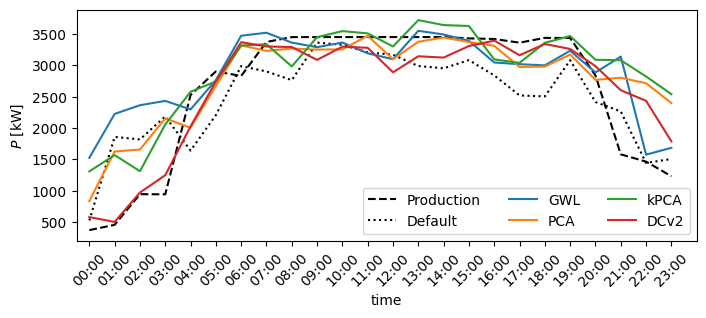

In [12]:
import matplotlib.pyplot as plt
import joblib

forecasts = joblib.load("/p/project/deepacf/maelstrom/emmerich1/data/forecasts-per-method.joblib")

turbine_path = turbine_files[WORKER_ID]
turbine_name = turbine_path.name.replace(".nc", "")
turbine_path: pathlib.Path = (
    preprocessed_data_dir / f"{turbine_name}/turbine.nc"
)
turbine = xr.open_dataset(turbine_path)
print(turbine)

forecast, date = forecasts["PCA"]
x = list(range(forecast.size))
xticklabels = [s.strftime("%H:%M") for s in pd.date_range(start="2000-01-01", end="2000-01-02", freq="1h")][:-1]

plt.figure(figsize=(8, 3))

actual = a6.datasets.methods.select.select_for_date(turbine, date=date)[
    turbine_variables.production
]

plt.plot(x, actual, label="Production", color="black", linestyle="--")

plt.plot(x, forecasts["Default"][0], label="Default", color="black", linestyle=":")

for method, (forecast, _) in forecasts.items():
    if method == "Default":
        continue
    plt.plot(x, forecast, label=method)
    
plt.xticks()
plt.legend(ncol=3)
plt.ylabel("$P$ [kW]")

plt.xticks(x, xticklabels, rotation=45)
plt.xlabel("time")

plt.xlim(-0.5, 24)
plt.savefig(plots / "forecasts-per-method.pdf")

In [74]:
coordinates = []

for i, turbine_path in enumerate(turbines_with_preprocessed_data):
    turbine = xr.open_dataset(turbine_path)
    lon, lat = turbine["longitude"].values.tolist(), turbine["latitude"].values.tolist()
    coordinates.append((lon, lat))

RANK 4 (LOCAL 4) - DEBUG - 2024-04-09 11:45:42 - 0:01:51 - Loaded backend module://matplotlib_inline.backend_inline version unknown.
RANK 4 (LOCAL 4) - DEBUG - 2024-04-09 11:45:42 - 0:01:51 - Loaded backend module://matplotlib_inline.backend_inline version unknown.


RANK 4 (LOCAL 4) - DEBUG - 2024-04-09 11:45:42 - 0:01:51 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
RANK 4 (LOCAL 4) - DEBUG - 2024-04-09 11:45:42 - 0:01:51 - findfont: score(FontEntry(fname='/venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
RANK 4 (LOCAL 4) - DEBUG - 2024-04-09 11:45:42 - 0:01:51 - findfont: score(FontEntry(fname='/venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
RANK 4 (LOCAL 4) - DEBUG - 2024-04-09 11:45:42 - 0:01:51 - findfont: score(FontEntry(fname='/venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'

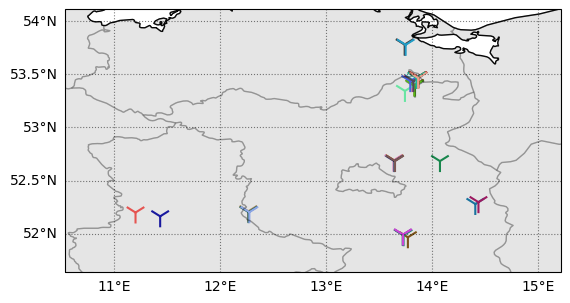

In [75]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shapereader
import cartopy.feature as cfeature

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor="none", linewidth=1)

# get country borders
resolution = "10m"
category = "cultural"
name = "admin_1_states_provinces"
shpfilename = shapereader.natural_earth(resolution, category, name)
adm1_shapes = list(shapereader.Reader(shpfilename).geometries())


x, y = [x[0] for x in coordinates], [x[1] for x in coordinates]
ax.scatter(x, y, marker="1", s=250, c=[a6.plotting._colors.LABEL_COLORS[i] for i in range(len(coordinates))])

# Just plotted to avoid calling `ax.set_extent()`, which crashes the kernel
ax.scatter(
    [10.75, 15.0, 10.75, 15.0], # longitudes
    [51.75, 51.75, 54.0, 54.0], # latitudes
    alpha=0,
)

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(),
                  edgecolor='black', facecolor='gray', alpha=0.2)

ax.gridlines(crs=ccrs.PlateCarree(), color='black', alpha=0.5, linestyle=':', draw_labels=["left", "bottom"])

plt.savefig(plots / "turbine-positions.pdf")

In [82]:
def extract_turbine_data(path: pathlib.Path):
    d = xr.open_dataset(path)
    lat, lon = float(d["latitude"]), float(d["longitude"])
    altitude = float(d["level"])
    power_rating = float(d.attrs["power rating"].split(" ")[0]) * 1e-3
    hub_height = float(d.attrs["hub height"].split(" ")[0])
    start, end = (
        utils.times.numpy_datetime64_to_datetime(
            d["time"][0].values
        ).strftime("%Y-%m-%d"),
        utils.times.numpy_datetime64_to_datetime(
            d["time"][-1].values
        ).strftime("%Y-%m-%d"),
    )
    return [f"{lat:.1f}", f"{lon:.1f}", f"{altitude:.1f}", f"{hub_height:.0f}", f"{power_rating:.1f}", start, end]


data = [
    extract_turbine_data(path)
    for path in turbines_with_preprocessed_data
]
df = pd.DataFrame(
    data=data,
    columns=["Lat.", "Lon.", "Alt. [m]", "Hub height [m]", "Power rating [MW]", "Start date", "End date"],
)
code = df.to_latex(
    float_format="%.2f",
    label="turbines",
    index=False,
    column_format="rrrrrcc",
    caption="""
    Properties of the wind turbines.
	Shown are the geographical position (latitude, longitude, altitude),
	hub height and power rating (or nominal power output),
	and start and end date of the available power production data
	of the respective turbine.
    """,
)

    
with open("/p/home/jusers/emmerich1/juwels/code/a6/notebooks/turbines-table.tex", "w") as f:
    f.write(code)

df

,Lat.,Lon.,Alt. [m],Hub height [m],Power rating [MW],Start date,End date
0,53.4,13.8,53.0,135,3.6,2019-09-09,2021-07-18
1,53.4,13.8,63.0,123,4.2,2019-09-12,2021-07-18
2,53.4,13.8,47.0,123,4.2,2019-09-30,2021-07-18
3,52.2,11.2,151.5,60,0.8,2017-01-01,2021-07-18
4,52.7,14.1,75.0,105,2.0,2017-01-01,2021-07-18
5,52.3,14.4,93.0,105,2.0,2017-01-01,2021-07-18
6,52.3,14.4,89.0,108,2.0,2017-01-01,2021-07-18
7,53.8,13.7,9.0,105,2.0,2017-01-01,2021-07-18
8,52.0,13.8,52.4,149,3.5,2018-12-13,2021-07-18
9,52.2,11.4,126.0,95,2.0,2017-01-01,2021-07-18


In [11]:
import dataclasses
import datetime

@dataclasses.dataclass
class ErrorsPerLswr:
    label: int
    measurements: list[int] = dataclasses.field(default_factory=list)
    nmae: list[int] = dataclasses.field(default_factory=list)
    nrmse: list[int] = dataclasses.field(default_factory=list)

def get_errors_per_lswr(data: xr.Dataset) -> dict[int, ErrorsPerLswr]:
    modes = a6.modes.methods.determine_lifetimes_of_modes(data)
    dates = [xr.DataArray(list(mode.get_dates())) for mode in modes]
    
    errors_per_mode = {mode.label: ErrorsPerLswr(label=mode.label) for mode in modes}

    for i, turbine in enumerate(errors):
        print(f"{data.name}: {i}/{len(errors)}", end="\r")

        for mode, date in zip(modes, dates, strict=True):
            mode_power = errors_per_mode[mode.label]
            
            # Get time steps of production where LSWR appeared
            intersection = sorted(set(turbine.time.values) & set(date.values))
            
            if not intersection:
                logger.warning(f"{data.name}: empty intersection for {i} and mode {mode.label}")
                continue

            turbine_sub = turbine.sel(time=intersection, lswr_method="Default")

            # Count number of days that contribute to the results
            mode_power.measurements.append(len(intersection))

            # Select time steps of LSWR appearance and calculate mean
            nmae = turbine_sub["nmae"]
            mode_power.nmae.extend(nmae.values.flatten().tolist())

            nrmse = turbine_sub["nrmse"]
            mode_power.nrmse.extend(nrmse.values.flatten().tolist())

    return errors_per_mode

errors_per_method = {
    lswr.name: get_errors_per_lswr(lswr)
    for lswr in lswrs
    if lswr is not None
}

RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:13 - 0:03:09 - GWL: empty intersection for 0 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:13 - 0:03:09 - GWL: empty intersection for 0 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:13 - 0:03:09 - GWL: empty intersection for 1 and mode 17


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:13 - 0:03:09 - GWL: empty intersection for 1 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:09 - GWL: empty intersection for 2 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:09 - GWL: empty intersection for 2 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:09 - GWL: empty intersection for 3 and mode 8
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:09 - GWL: empty intersection for 3 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:09 - GWL: empty intersection for 3 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:09 - GWL: empty intersection for 3 and mode 31
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:09 - GWL: empty intersection for 3 and mode 32
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:09 - GWL: empty intersection for 3 and mode 37


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:09 - GWL: empty intersection for 4 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:09 - GWL: empty intersection for 4 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:09 - GWL: empty intersection for 5 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:09 - GWL: empty intersection for 5 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:09 - GWL: empty intersection for 6 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:09 - GWL: empty intersection for 6 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:10 - GWL: empty intersection for 7 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:10 - GWL: empty intersection for 7 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:10 - GWL: empty intersection for 8 and mode 8
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:10 - GWL: empty intersection for 8 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:10 - GWL: empty intersection for 8 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:10 - GWL: empty intersection for 8 and mode 31
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:10 - GWL: empty intersection for 8 and mode 32
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:10 - GWL: empty intersection for 8 and mode 37


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:10 - GWL: empty intersection for 9 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:10 - GWL: empty intersection for 9 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:10 - GWL: empty intersection for 10 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:14 - 0:03:10 - GWL: empty intersection for 10 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:10 - GWL: empty intersection for 11 and mode 8
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:10 - GWL: empty intersection for 11 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:10 - GWL: empty intersection for 11 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:10 - GWL: empty intersection for 11 and mode 31
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:10 - GWL: empty intersection for 11 and mode 32
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:10 - GWL: empty intersection for 11 and mode 37
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:10 - GWL: empty intersection for 12 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:10 - GWL: empty intersection for 12 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:10 - GWL: empty intersection for 13 and mode 17


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:10 - GWL: empty intersection for 13 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:10 - GWL: empty intersection for 14 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:10 - GWL: empty intersection for 14 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:11 - GWL: empty intersection for 15 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:11 - GWL: empty intersection for 15 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:11 - GWL: empty intersection for 16 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:11 - GWL: empty intersection for 16 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:11 - GWL: empty intersection for 17 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:11 - GWL: empty intersection for 17 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:11 - GWL: empty intersection for 18 and mode 8
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:11 - GWL: empty intersection for 18 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:15 - 0:03:11 - GWL: empty intersection for 18 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:16 - 0:03:11 - GWL: empty intersection for 19 and mode 17


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:16 - 0:03:11 - GWL: empty intersection for 19 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:16 - 0:03:11 - GWL: empty intersection for 20 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:16 - 0:03:11 - GWL: empty intersection for 20 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:16 - 0:03:11 - GWL: empty intersection for 21 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:16 - 0:03:11 - GWL: empty intersection for 21 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:16 - 0:03:12 - GWL: empty intersection for 22 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:16 - 0:03:12 - GWL: empty intersection for 22 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:16 - 0:03:12 - GWL: empty intersection for 23 and mode 17


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:16 - 0:03:12 - GWL: empty intersection for 23 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:16 - 0:03:12 - GWL: empty intersection for 24 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:16 - 0:03:12 - GWL: empty intersection for 24 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:16 - 0:03:12 - GWL: empty intersection for 25 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:17 - 0:03:12 - GWL: empty intersection for 25 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:17 - 0:03:12 - GWL: empty intersection for 26 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:17 - 0:03:12 - GWL: empty intersection for 26 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:17 - 0:03:12 - GWL: empty intersection for 27 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:17 - 0:03:12 - GWL: empty intersection for 27 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:17 - 0:03:12 - GWL: empty intersection for 28 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:17 - 0:03:12 - GWL: empty intersection for 28 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:17 - 0:03:12 - GWL: empty intersection for 29 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:17 - 0:03:12 - GWL: empty intersection for 29 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:17 - 0:03:13 - GWL: empty intersection for 30 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:17 - 0:03:13 - GWL: empty intersection for 30 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:17 - 0:03:13 - GWL: empty intersection for 31 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:17 - 0:03:13 - GWL: empty intersection for 31 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:17 - 0:03:13 - GWL: empty intersection for 32 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:17 - 0:03:13 - GWL: empty intersection for 32 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:17 - 0:03:13 - GWL: empty intersection for 33 and mode 17


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:18 - 0:03:13 - GWL: empty intersection for 33 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:18 - 0:03:13 - GWL: empty intersection for 34 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:18 - 0:03:13 - GWL: empty intersection for 34 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:18 - 0:03:13 - GWL: empty intersection for 35 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:18 - 0:03:13 - GWL: empty intersection for 35 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:18 - 0:03:13 - GWL: empty intersection for 36 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:18 - 0:03:13 - GWL: empty intersection for 36 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:18 - 0:03:14 - GWL: empty intersection for 37 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:18 - 0:03:14 - GWL: empty intersection for 37 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:18 - 0:03:14 - GWL: empty intersection for 38 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:18 - 0:03:14 - GWL: empty intersection for 38 and mode 27
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:18 - 0:03:14 - GWL: empty intersection for 39 and mode 17
RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:18 - 0:03:14 - GWL: empty intersection for 39 and mode 27


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:20 - 0:03:15 - PCA: empty intersection for 3 and mode 7


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:20 - 0:03:16 - PCA: empty intersection for 8 and mode 7


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:21 - 0:03:16 - PCA: empty intersection for 11 and mode 7


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:26 - 0:03:21 - kPCA: empty intersection for 3 and mode 40


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:26 - 0:03:22 - kPCA: empty intersection for 8 and mode 40


RANK 4 (LOCAL 4) - WARNING - 2024-04-03 16:44:27 - 0:03:22 - kPCA: empty intersection for 11 and mode 40


In [ ]:
import pandas as pd

def errors_mean_with_std_as_string(stats: list[float]) -> str:
    return f"${np.nanmean(stats) * 100:.2f} \pm {np.nanstd(stats) * 100:.2f}$"

latex_code = []
columns = {
    "$N$": lambda lswrs: [np.nansum(results.measurements) for results in lswrs.values()],
    "NMAE [\%]": lambda lswrs: [errors_mean_with_std_as_string(results.nmae) for results in lswrs.values()],
    "NRMSE [\%]": lambda lswrs: [errors_mean_with_std_as_string(results.nrmse) for results in lswrs.values()],
}

reform = {
    (name, column): func(method) for name, method in errors_per_method.items() for column, func in columns.items()
}

df = pd.DataFrame.from_dict(reform)

# Add 1 to start indexing at 1 to be conform with LSWR labels
df.index += 1

code = df.to_latex(
    float_format="%.2f",
    label="errors-per-lswr-per-method",
    caption=f"Normalized MAE and RMSE of the Default model for the resulting LSWRs.",
)

    
with open("/p/home/jusers/emmerich1/juwels/code/a6/notebooks/errors-table.tex", "w") as f:
    f.write(code)


df

In [ ]:
import pandas as pd
import dataclasses
import datetime

start, end = min(min(turbine.time.values) for turbine in errors), max(max(turbine.time.values) for turbine in errors)
date_range = pd.date_range(start, end, freq="1d")
date_range


@dataclasses.dataclass
class ErrorsPerDay:
    time: pd.Timestamp
    measurements: int = 0
    nmae: list[int] = dataclasses.field(default_factory=list)
    nrmse: list[int] = dataclasses.field(default_factory=list)

def get_errors_per_day(data: xr.DataArray | None) -> dict[pd.Timestamp, ErrorsPerDay]:
    name = data.name if data is not None else "Default"
    errors_per_day = {step: ErrorsPerDay(time=step) for step in date_range}

    for i, step in enumerate(date_range):
        day_errors = errors_per_day[step]

        for j, turbine in enumerate(errors):
            print(f"{name}: day {i}/{len(date_range)}, turbine {j}/{len(errors)}", end="\r")
            
            if step not in turbine["time"]:
                continue

            turbine_sub = turbine.sel(time=step, lswr_method=name)

            # Add to counter for turbines that contribute to the results
            day_errors.measurements += 1

            # Select time steps of LSWR appearance and calculate mean
            nmae = turbine_sub["nmae"]
            day_errors.nmae.append(nmae.values.tolist())

            nrmse = turbine_sub["nrmse"]
            day_errors.nrmse.append(nrmse.values.tolist())

    return errors_per_day

errors_per_day = {
    (lswr.name if lswr is not None else "Default"): get_errors_per_day(lswr)
    for lswr in lswrs
}

In [ ]:
import matplotlib.pyplot as plt

n_rows = 5

fig, axs = plt.subplots(figsize=(12, 4*n_rows), nrows=n_rows, ncols=1, sharex=True)

means_per_day = []
stds_per_day = []

attr = "nmae"

for results in errors_per_day.values():
    mean_per_day = np.array([np.nanmean(getattr(day, attr)) for day in results.values()]) * 100
    std_per_day = np.array([np.nanstd(getattr(day, attr)) for day in results.values()]) * 100

    means_per_day.append(mean_per_day)
    stds_per_day.append(std_per_day)

x_start, x_end = 100, 300

global_max = np.nanmax([np.nanmax(m[x_start:x_end]+s[x_start:x_end]) for m, s in zip(means_per_day, stds_per_day)])
global_min = np.nanmin([np.nanmin(m[x_start:x_end]-s[x_start:x_end]) for m, s in zip(means_per_day, stds_per_day)])

# If global minimum is lower than 2%, set it to 0.
# This is used for the ylim in each plot
if global_min < 2.0:
    global_min = 0.0

x = list(range(len(date_range)))

for i, (name, results) in enumerate(errors_per_day.items()):
    ax = axs[i]

    mean_per_day = means_per_day[i]
    std_per_day = stds_per_day[i]

    all_errs = np.array([nrmse for day in results.values() for nrmse in getattr(day, attr)]) * 100
    global_mean = np.nanmean(all_errs)
    global_std = np.nanstd(all_errs)

    ax.plot(
        x,
        mean_per_day,
    )
    ax.fill_between(
        x,
        mean_per_day-std_per_day,
        mean_per_day+std_per_day,
        color="gray",
        alpha=0.5,
    )

    # Plot global mean and standard deviation
    ax.hlines(
        y=global_mean,
        xmin=-10,
        xmax=x[-1] + 10,
        linewidth=1,
        linestyle="--",
        color="black",
        label=rf"$\mu_\mathrm{{{attr.upper()}}}^\mathrm{{global}} = ({global_mean:.2f} \pm {global_std:.2f})\,\%$"
    )

    ax.hlines(
        y=global_mean+global_std,
        xmin=-10,
        xmax=x[-1] + 10,
        linewidth=1,
        linestyle=":",
        color="black",
    )
    ax.hlines(
        y=global_mean-global_std,
        xmin=-10,
        xmax=x[-1] + 10,
        linewidth=1,
        linestyle=":",
        color="black",
    )

    ax.set_title(name)

    ax.set_xlim(x_start, x_end)

    if i == n_rows - 1: 
        ax.set_xlabel("time")
        xticks = ax.get_xticks()
        xticklabels = [date_range[int(tick)].strftime("%Y-%m-%d") for tick in xticks[1:]]
        ax.set_xticklabels(xticklabels, rotation=45)
    else:
        ax.set_xticklabels([])

    ax.set_ylabel(rf"$\mu_\mathrm{{{attr.upper()}}}$ [%]")

    ax.set_ylim(global_min * 0.9, global_max * 1.05)
    ax.legend()

fig.tight_layout()
plt.savefig(plots / f"forecast-error-timeseries-per-lswr-method-{attr}.pdf")